# Numerical Methods for Pricing Rainbow Options

In [ ]:
#If needded: libraries installation 
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install tqdm
!pip install seaborn
!pip install yfinance

### Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.sparse import diags
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm.notebook import tqdm
import time
import yfinance as yf
%matplotlib inline

### Example data

In [2]:
dt = 1/252
t_max = 3/12  
t = np.arange(0, t_max+dt, dt)
t[-1]=-0.0001
nt=len(t)

ds1 = 2.
ds2 = 2.
s1_max = 100
s2_max = 100

S1 = np.arange(0, s1_max+ds1, ds1)
S2 = np.arange(0, s2_max+ds2, ds2)
ns1=len(S1)
ns2=len(S2)

sigma1=0.2
sigma2=0.3
rho=0.7
r=0.02
K=30

In [3]:
#Error measurement formulas
def rmse(Y_t, Y_p):
    return np.sqrt( np.mean((Y_t - Y_p) ** 2) )

def rmdse(Y_t, Y_p):
    return np.sqrt( np.median((Y_t - Y_p) ** 2) )

def mae(Y_t, Y_p):
    return np.mean(abs(Y_t-Y_p))

def mdape(Y_t, Y_p):
    l=[]
    for i in range(Y_t.shape[0]):
        for j in range(Y_t.shape[1]):
            if Y_t[i,j]!=0:
                l.append(abs(Y_t[i,j]-Y_p[i,j])/Y_t[i,j])
    
    return np.median(l)*100

def mae_mean(Y_t, Y_p):
    return (mae(Y_t, Y_p)/np.mean(Y_t))*100

### Black Scholes exact formula for a Rainbow max call Option with two underlyings 

In [4]:
def rainbow_MaxCall(S1,S2,K,T,r,sigma1,sigma2,rho):
    sigma_sq=sigma1**2+sigma2**2-2*rho*sigma1*sigma2
    rho1=( sigma1 - rho*sigma2 )/np.sqrt(sigma_sq)
    rho2=( sigma2 - rho*sigma1 )/np.sqrt(sigma_sq)
    
    d=( np.log(S1)-np.log(S2) + 0.5*sigma_sq*T ) / np.sqrt(sigma_sq*T)
    y1=( np.log(S1/K) + (r+0.5*(sigma1**2))*T ) / (sigma1*np.sqrt(T))
    y2=( np.log(S2/K) + (r+0.5*(sigma2**2))*T ) / (sigma2*np.sqrt(T))
    
    M1=multivariate_normal(mean=np.array([0,0]),cov=np.array([[1,rho1],[rho1,1]]))
    M2=multivariate_normal(mean=np.array([0,0]),cov=np.array([[1,rho2],[rho2,1]]))
    M3=multivariate_normal(mean=np.array([0,0]),cov=np.array([[1,rho],[rho,1]]))
    
    V=S1*M1.cdf([y1,d])+S2*M2.cdf([y2,-d+np.sqrt(sigma_sq*T)])-K*np.exp(-r*T)*(1-M3.cdf([-y1+sigma1*np.sqrt(T),-y2+sigma2*np.sqrt(T)]))
    #V=S1*M1.cdf([y1,-d])+S2*M2.cdf([y2,d-np.sqrt(sigma_sq*T)])-K*np.exp(-r*T)*(M3.cdf([y1-sigma1*np.sqrt(T),y2-sigma2*np.sqrt(T)]))

    return V

rainbow_formula=np.vectorize(rainbow_MaxCall)

#To avoid log errors
stock1=S1.copy()
stock1[0]+=0.00001
stock2=S2.copy()
stock2[0]+=0.00001

#Black Scholes value for each grid point (t=T)
BS_V=np.zeros((ns1,ns2))
for j in tqdm(range(ns2)):
    BS_V[:,j]=rainbow_formula(stock1,stock2[j],K,t_max,r,sigma1,sigma2,rho)

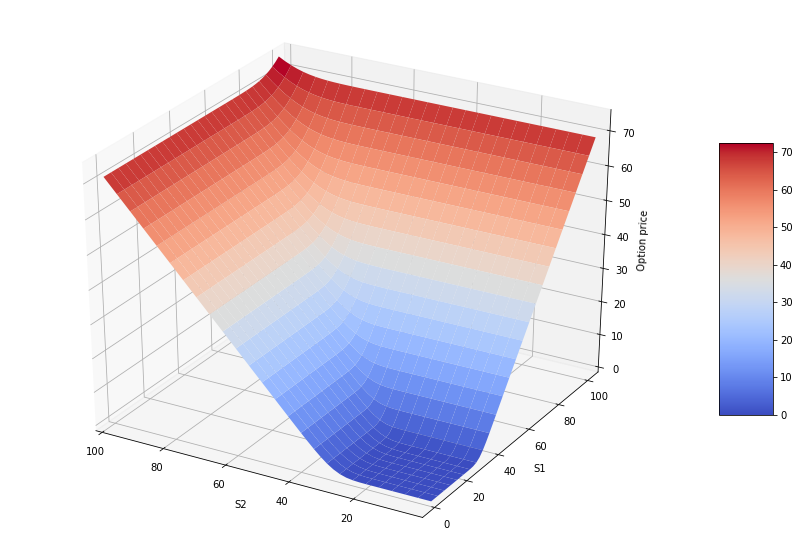

In [5]:
#3D Graph
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111, projection='3d')

Y,X=np.meshgrid(S1,S2)

ax.set_xlim(s2_max)
ax.set_xlabel('S2')
ax.set_ylabel('S1')
ax.set_zlabel('Option price')
pl=ax.plot_surface(Y,X,BS_V,cmap=cm.coolwarm)
fig.colorbar(pl,shrink=0.5,aspect=5)

### Montecarlo Method

In [6]:
def MC_rainbow(T,dt,iterations,S1,S2,K,r,sigma1,sigma2,rho):
    
    #Wiener processes 
    Z1=np.random.standard_normal(iterations)
    Z2=np.random.standard_normal(iterations)
   
    #Price paths
    S1_path=S1*np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * np.sqrt(dt) * Z1)
    
    #Choleski transoformation affects S2 path
    S2_path=S2*np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * np.sqrt(dt) * (rho*Z1+np.sqrt(1-rho**2)*Z2))
   
    #Payoff
    payoff=np.maximum(np.maximum(S1_path,S2_path)-K,0)
    
    #Option price and std
    op_price=np.exp(-r*T)*np.mean(payoff)
    std=np.exp(-r*T)*np.std(payoff)/np.sqrt(iterations)
    
    return op_price, std

#Compute montecarlo for each grid point (t=T)
MC=np.vectorize(MC_rainbow)

MC_V=np.zeros((ns1,ns2))
MC_std=[]
for j in tqdm(range(ns2)):
    value=MC(t_max,t_max,50000,S1,S2[j],K,r,sigma1,sigma2,rho)
    MC_V[:,j]=value[0]
    MC_std.append(value[1])

Error measurements 
RMSE: 0.04063221184119249 
RMdSE 0.021986728195500405 
MAE 0.02953292916422682 
MdAPE % 0.07775961557679344 
MAE/MEAN % 0.07710819574367392 
Average MC St.dev 0.04043213088993331


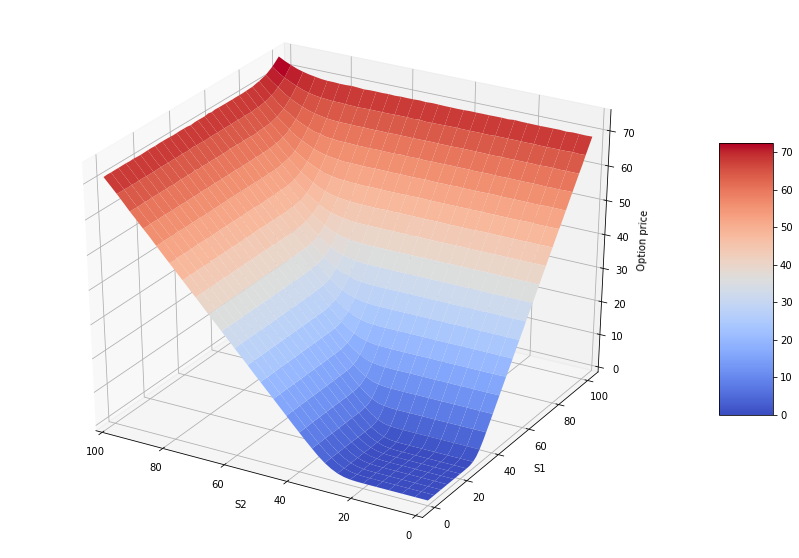

In [7]:
#3D Graph
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111, projection='3d')

Y,X=np.meshgrid(S1,S2)

ax.set_xlim(100,0)
ax.set_xlabel('S2')
ax.set_ylabel('S1')
ax.set_zlabel('Option price')
pl=ax.plot_surface(Y,X,MC_V,cmap=cm.coolwarm)
fig.colorbar(pl,shrink=0.5,aspect=5)

print('Error measurements','\nRMSE:',rmse(BS_V,MC_V),'\nRMdSE',rmdse(BS_V,MC_V),
     '\nMAE',mae(BS_V,MC_V),'\nMdAPE %',mdape(BS_V,MC_V),'\nMAE/MEAN %',mae_mean(BS_V,MC_V), 
      '\nAverage MC St.dev', np.sqrt(np.mean(np.array(MC_std)**2)))

### Antithetic Variables

In [8]:
def AnMC_rainbow(T,dt,iterations,S1,S2,K,r,sigma1,sigma2,rho):
    
    #Wiener processes 
    Z1=np.random.standard_normal(iterations)
    Z2=np.random.standard_normal(iterations)
   
    #Price paths
    S1_plus=S1*np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * np.sqrt(dt) * Z1)
    S1_minus=S1*np.exp((r - 0.5 * sigma1**2) * dt - sigma1 * np.sqrt(dt) * Z1)
    
    #Choleski transoformation affects S2 path
    S2_plus=S2*np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * np.sqrt(dt) * (rho*Z1+np.sqrt(1-rho**2)*Z2))
    S2_minus=S2*np.exp((r - 0.5 * sigma2**2) * dt - sigma2 * np.sqrt(dt) * (rho*Z1+np.sqrt(1-rho**2)*Z2))
    
    #Payoffs
    payoff_plus=np.maximum(np.maximum(S1_plus,S2_plus)-K,0)
    payoff_minus=np.maximum(np.maximum(S1_minus,S2_minus)-K,0)
    payoff=0.5*(payoff_plus+payoff_minus)
    
    #Option price
    op_price=np.exp(-r*T)*np.mean(payoff)
    std=stdev_MC = np.exp(-r*T)*np.std(payoff)/np.sqrt(iterations)
    
    return op_price, std

#Compute Montecarlo for each node of the grid (t=T)
AnMC=np.vectorize(AnMC_rainbow)

AnMC_V=np.zeros((ns1,ns2))
AnMC_std=[]
for j in tqdm(range(ns2)):
    value=AnMC(t_max,t_max,50000,S1,S2[j],K,r,sigma1,sigma2,rho)
    AnMC_V[:,j]=value[0]
    AnMC_std.append(value[1])

Error measurements 
RMSE: 0.0052452071405842075 
RMdSE 0.002310183097192109 
MAE 0.003497380637944485 
MdAPE % 0.007520331162784219 
Average MC St.dev 0.005303633735637863


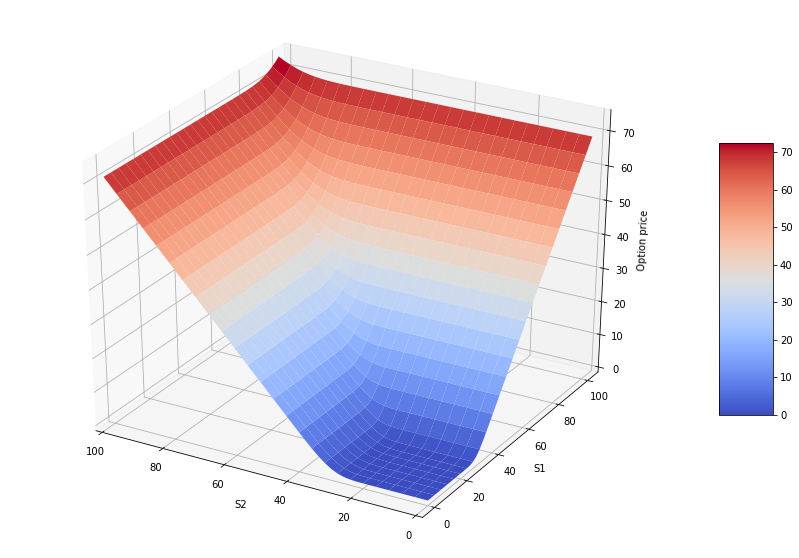

In [9]:
#3D Graph
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111, projection='3d')

Y,X=np.meshgrid(S1,S2)

ax.set_xlim(100,0)
ax.set_xlabel('S2')
ax.set_ylabel('S1')
ax.set_zlabel('Option price')
pl=ax.plot_surface(Y,X,AnMC_V,cmap=cm.coolwarm)
fig.colorbar(pl,shrink=0.5,aspect=5)

print('Error measurements','\nRMSE:',rmse(BS_V,AnMC_V),'\nRMdSE',rmdse(BS_V,AnMC_V),
     '\nMAE',mae(BS_V,AnMC_V),'\nMdAPE %',mdape(BS_V,AnMC_V), 
      '\nAverage MC St.dev', np.sqrt(np.mean(np.array(AnMC_std)**2)) )

### Implicit FDM

In [10]:
#Auxiliar functions

#Black Scholes formula for vanilla call option
def call(T,X,S,r,sigma):
    d1=(np.log(S/X)+(r+(sigma**2)/2)*T)/(sigma*(T**0.5))
    d2=d1-sigma*(T**0.5)
    c=S*norm.cdf(d1)-X*np.exp(-r*T)*norm.cdf(d2)
    return c
call_vanilla=np.vectorize(call)

#Margrabe formula for the exchange option
def exchange_bs(S1,S2,r,T,sigma1,sigma2,rho):
    sigma_sq=sigma1**2+sigma2**2-2*rho*sigma1*sigma2
    d1=( np.log(S1/S2) + 0.5*sigma_sq*T ) / np.sqrt(sigma_sq*T)
    d2=( np.log(S1/S2) - 0.5*sigma_sq*T ) / np.sqrt(sigma_sq*T)
    V=S1*norm.cdf(d1)-S2*norm.cdf(d2)
    return V
exchange_call=np.vectorize(exchange_bs)

#Function which creates a tridiagonal matrix of matrices
def diag_matrix(n,a,b,c,d,e,f):
    M=np.zeros((n**2,n**2+2*n))
    for j in range(1,n+1):
        A1=diags([-f[2:-1,j], -e[1:-1,j], f[1:-1,j]], [-1, 0, 1], shape=(n, n)).toarray()
        A2=diags([-b[2:-1,j], 1-c[1:-1,j], -a[1:-1,j]], [-1, 0, 1], shape=(n, n)).toarray()
        A3=diags([f[2:-1,j], -d[1:-1,j], -f[1:-1,j]], [-1, 0, 1], shape=(n, n)).toarray()
        concat_m=np.concatenate((A1,A2,A3),axis=1)
        M[(j-1)*n:concat_m.shape[0]+(j-1)*n,(j-1)*n:concat_m.shape[1]+(j-1)*n]=concat_m
    return M[:,n:-n]

#Function that creates the boundary conditions matrix for specified time x
def boundary_matrix(V,ns,x,a,b,c,d,e,f):
    H1=np.zeros(ns-2)
    for i in range(1,ns-1):
        H1[i-1]=np.dot(np.array([-f[i,1],-e[i,1],f[i,1]]),V[x,i-1:i+2,0])

    H1[0]+=(-b[1,1]*V[x,0,1]+f[1,1]*V[x,0,2])
    H1[-1]+=(-a[-2,1]*V[x,-1,1]-f[-2,1]*V[x,-1,2])

    H2=np.zeros(ns-2)
    for i in range(1,ns-1):
        H2[i-1]=np.dot(np.array([f[i,-2],-d[i,-2],-f[i,-2]]),V[x,i-1:i+2,-1])

    H2[0]+=(-f[1,-2]*V[x,0,-3]-b[1,-2]*V[x,0,-2])
    H2[-1]+=(f[-2,-2]*V[x,-1,-3]-a[-2,-2]*V[x,-1,-2])

    H3=np.zeros((ns-4)*(ns-2))
    for i in range(2,ns-2):
        H3[(i-2)*(ns-2)]=np.dot(np.array([-f[1,i],-b[1,i],f[1,i]]),V[x,0,i-1:i+2])
        H3[(i-2)*(ns-2)+ns-3]=np.dot(np.array([f[-2,i],-a[-2,i],-f[-2,i]]),V[x,-1,i-1:i+2])
        
    return np.concatenate((H1,H3,H2))

In [11]:
def implicit_FDM(t_max,dt,s1_max,ds1,s2_max,ds2,r,K,sigma1,sigma2,rho):
    S1 = np.arange(0, s1_max+ds1, ds1)
    S2 = np.arange(0, s2_max+ds2, ds2)

    t = np.arange(0, t_max+dt, dt)
    t[-1]=-0.00001

    nt=len(t)
    ns1=len(S1)
    ns2=len(S2)
    
    #To avoid log errors 
    S1_=S1.copy()
    S2_=S2.copy()
    S1_[0]+=0.00001
    S2_[0]+=0.00001

    V= np.zeros((nt, ns1, ns2))
    #Condition S1=0
    for x in range(nt):
        V[x,0,:] = call_vanilla(t_max-t[x],K,S2_,r,sigma2)
    
    #Condition S2=0
    for x in range(nt):
        V[x,:,0] = call_vanilla(t_max-t[x],K,S1_,r,sigma1)   
    
    #Condition S1=S1_max
    for x in range(nt):
        V[x,-1,:]=call_vanilla(t_max-t[x],K,S2_+exchange_call(s1_max,S2_,r,t_max-t[x],sigma1,sigma2,rho),r,sigma1)

    #Condition S2=S2_max
    for x in range(nt):
        V[x,:,-1]=call_vanilla(t_max-t[x],K,S1_+exchange_call(s2_max,S1_,r,t_max-t[x],sigma1,sigma2,rho),r,sigma2)
        
    #Terminal nodes
    for n in range(ns1):
        for m in range(ns2):
            V[-1,n,m]=max(np.maximum(S1_[n],S2_[m])-K,0)
        
    #Coefficients (in the 3D problem they are matrices)
    a,b,c,d,e,f=np.zeros((ns1,ns2)),np.zeros((ns1,ns2)),np.zeros((ns1,ns2)),np.zeros((ns1,ns2)),np.zeros((ns1,ns2)),np.zeros((ns1,ns2))
    for j in range(ns2):
        a[:,j]=0.5*dt*( r*(S1/ds1) + (sigma1**2)*((S1/ds1)**2) )
        b[:,j]=0.5*dt*( (sigma1**2)*((S1/ds1)**2) - r*(S1/ds1) )
        c[:,j]=-dt*( (sigma1**2)*((S1/ds1)**2) + (sigma2**2)*((S2[j]/ds2)**2) + r )
        d[:,j]=0.5*dt*( r*(S2[j]/ds2) + (sigma2**2)*((S2[j]/ds2)**2) )
        e[:,j]=0.5*dt*( (sigma2**2)*((S2[j]/ds2)**2) - r*(S2[j]/ds2) )
        f[:,j]=0.25*dt*sigma1*sigma2*rho*(S1/ds1)*(S2[j]/ds2)
    #Clarification: not all coefficients depend of both i & j, but for a better understanding of the script we use is that way

    #Tridiagonal matrix
    A=diag_matrix(ns1-2,a,b,c,d,e,f)
    
    #Reverse loop goes from t=t_max
    for x in tqdm(reversed(range(1,nt))):
        B=boundary_matrix(V,ns1,x-1,a,b,c,d,e,f)
        L=np.linalg.solve(A,V[x,1:-1,1:-1].T.flatten()-B)
        V[x-1,1:-1,1:-1]=L.reshape(ns1-2,ns2-2).T.copy()
        
    return V

FDM_V=implicit_FDM(t_max,dt,s1_max,ds1,s2_max,ds2,r,K,sigma1,sigma2,rho)


Error measurements 
RMSE: 0.011739413012595741 
RMdSE 1.6124100887361914e-05 
MAE 0.004861292793013812 
MdAPE % 0.0001746577192622969


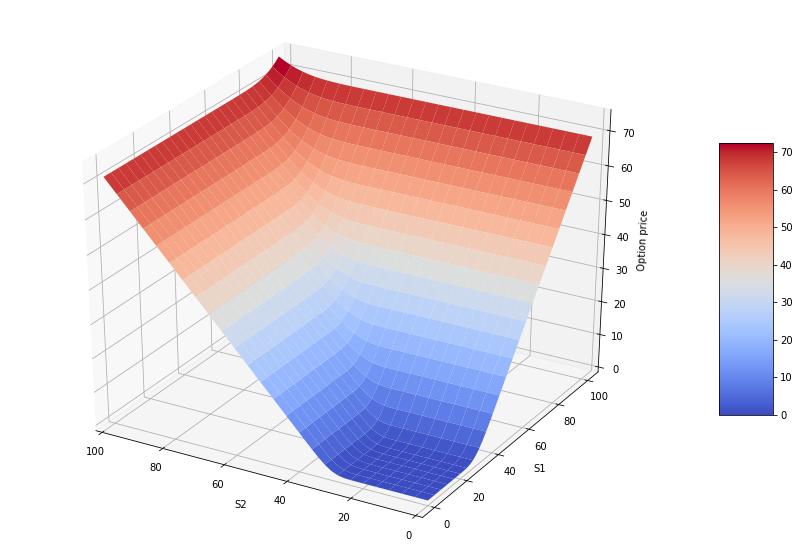

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111, projection='3d')

Y,X=np.meshgrid(S1,S2)

ax.set_xlim(s2_max,0)
ax.set_xlabel('S2')
ax.set_ylabel('S1')
ax.set_zlabel('Option price')
pl=ax.plot_surface(X,Y,FDM_V[0],cmap=cm.coolwarm)
fig.colorbar(pl,shrink=0.5,aspect=5)

print('Error measurements','\nRMSE:',rmse(BS_V,FDM_V[0]),'\nRMdSE',rmdse(BS_V,FDM_V[0]),
     '\nMAE',mae(BS_V,FDM_V[0]),'\nMdAPE %',mdape(BS_V,FDM_V[0]))

In [13]:
#Save performance measures in a df
performance_df=pd.DataFrame(index=['RMSE', 'RMdSE','MAE','MdAPE','MAE/MEAN'],columns=['Monte Carlo','Antithetic Monte Carlo','Implicit FDM'])
performance_df['Monte Carlo']=[rmse(BS_V,MC_V),rmdse(BS_V,MC_V),mae(BS_V,MC_V),mdape(BS_V,MC_V),mae_mean(BS_V,MC_V)]
performance_df['Antithetic Monte Carlo']=[rmse(BS_V,AnMC_V),rmdse(BS_V,AnMC_V),mae(BS_V,AnMC_V),mdape(BS_V,AnMC_V),mae_mean(BS_V,AnMC_V)]
performance_df['Implicit FDM']=[rmse(BS_V,FDM_V[0]),rmdse(BS_V,FDM_V[0]),mae(BS_V,FDM_V[0]),mdape(BS_V,FDM_V[0]),mae_mean(BS_V,FDM_V[0])]
performance_df

,Monte Carlo,Antithetic Monte Carlo,Implicit FDM
RMSE,0.040632,0.005245,0.011739
RMdSE,0.021987,0.002310,0.000016
MAE,0.029533,0.003497,0.004861
MdAPE,0.077760,0.007520,0.000175
MAE/MEAN,0.077108,0.009131,0.012692


### Pricing performance by zone (absolute error distribution)

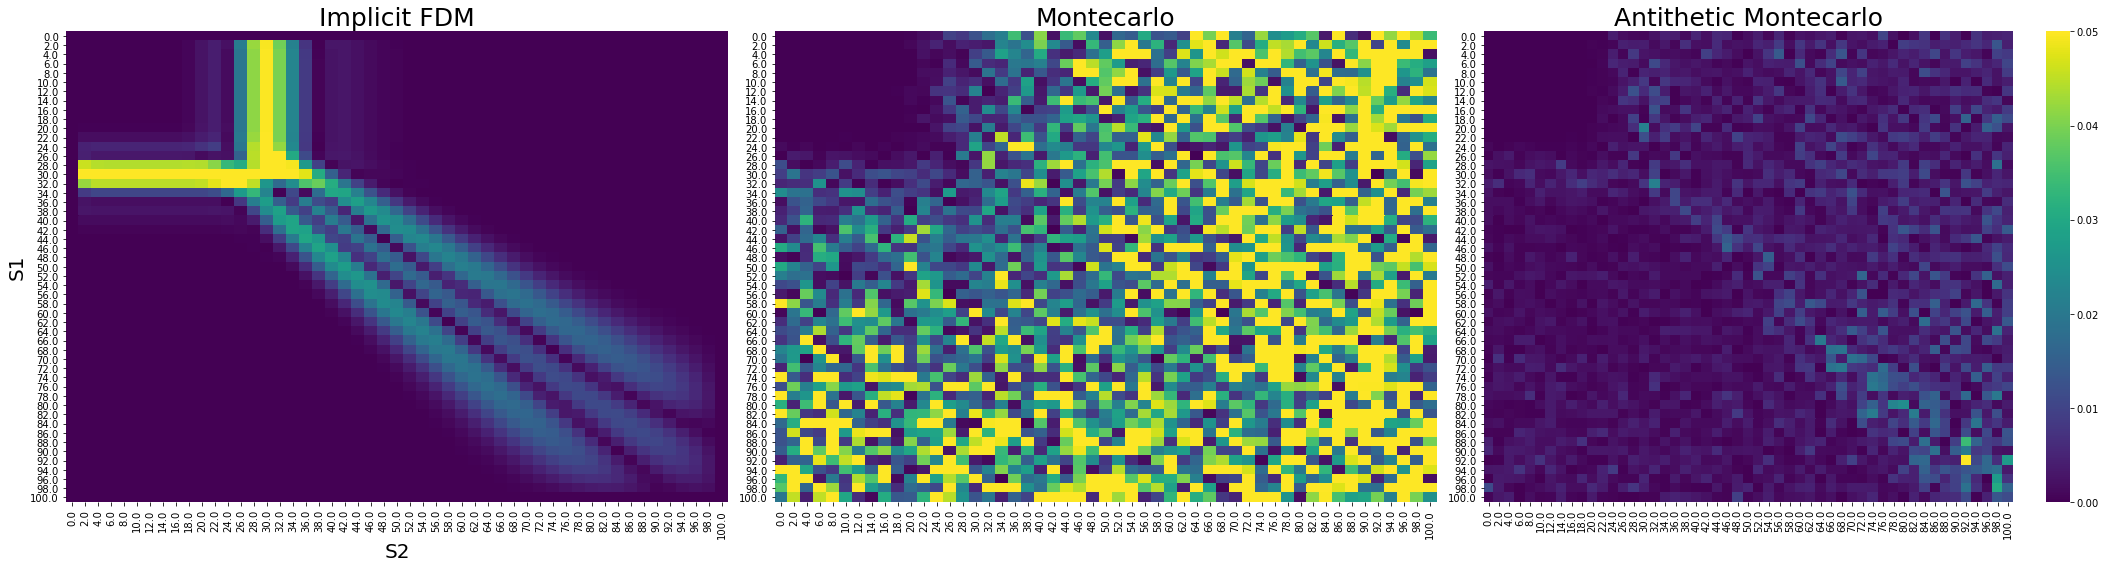

In [14]:
fig,ax=plt.subplots(1,3,figsize=(30,8))
ax[0].set_title('Implicit FDM',fontsize=25)
ax[1].set_title('Montecarlo',fontsize=25)
ax[2].set_title('Antithetic Montecarlo',fontsize=25)
sns.heatmap(abs(FDM_V[0]-BS_V),cmap='viridis',cbar=False,vmin=0,vmax=0.05, yticklabels=S1,xticklabels=S2,ax=ax[0])
sns.heatmap(abs(MC_V-BS_V),cmap='viridis',cbar=False, vmin=0,vmax=0.05,yticklabels=S1,xticklabels=S2,ax=ax[1])
sns.heatmap(abs(AnMC_V-BS_V),cmap='viridis',vmin=0,vmax=0.05, yticklabels=S1,xticklabels=S2,ax=ax[2])
ax[0].set_ylabel('S1',fontsize=20)
ax[0].set_xlabel('S2',fontsize=20)
plt.tight_layout()

### Computational cost vs Accuracy

In [15]:
sims=[1000,5000,10000,50000,100000,200000,500000,1000000]
ComptCost_df=pd.DataFrame(index=sims,columns=['MC elapsed time','MC MAE','MC av.std',
                                              'AnMC elapsed time','AnMC MAE','AnMC av.std'])

#### Montecarlo 

In [16]:
def run_montecarlo(M):
    MC_V=np.zeros((ns1,ns2))
    MC_std=[]
    for j in tqdm(range(ns2)):
        value=MC(t_max,t_max,M,S1,S2[j],K,r,sigma1,sigma2,rho)
        MC_V[:,j]=value[0]
        MC_std.append(value[1])
    return MC_V, MC_std

for it in tqdm(sims):
    t0 = time.time()
    V_matrix,stdev=run_montecarlo(it)
    ComptCost_df['MC elapsed time'].loc[it]=time.time() - t0
    ComptCost_df['MC MAE'].loc[it]=mae(BS_V,V_matrix)
    ComptCost_df['MC av.std'].loc[it]=np.sqrt(np.mean(np.array(stdev)**2))

#### Antithetic Montecarlo 

In [17]:
def run_ANmontecarlo(M):
    MC_V=np.zeros((ns1,ns2))
    MC_std=[]
    for j in tqdm(range(ns2)):
        value=AnMC(t_max,t_max,M,S1,S2[j],K,r,sigma1,sigma2,rho)
        MC_V[:,j]=value[0]
        MC_std.append(value[1])
    return MC_V, MC_std

for it in tqdm(sims):
    t0 = time.time()
    V_matrix,stdev=run_ANmontecarlo(it)
    ComptCost_df['AnMC elapsed time'].loc[it]=time.time() - t0
    ComptCost_df['AnMC MAE'].loc[it]=mae(BS_V,V_matrix)
    ComptCost_df['AnMC av.std'].loc[it]=np.sqrt(np.mean(np.array(stdev)**2))

#### Comparison

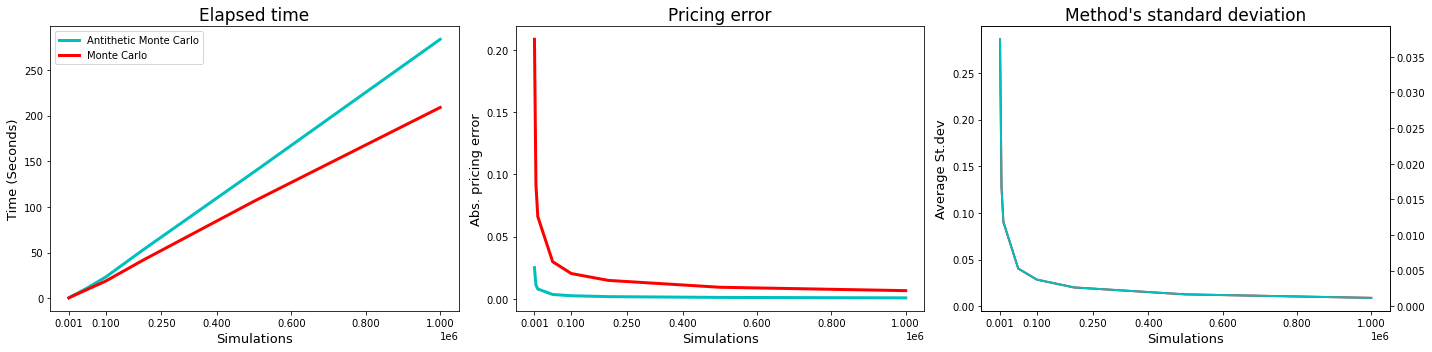

In [18]:
#Error and time convergence
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].set_xlabel('Simulations',fontsize=13)
ax[0].set_ylabel('Time (Seconds)',fontsize=13)
ax[0].plot(sims, ComptCost_df['AnMC elapsed time'],'c',label='Antithetic Monte Carlo',linewidth=3)
ax[0].plot(sims, ComptCost_df['MC elapsed time'],'r',label='Monte Carlo',linewidth=3)
ax[0].set_xticks([1000,100000,250000,400000,600000,800000,1000000])
ax[0].set_title('Elapsed time',fontsize=17)
ax[0].legend(loc=0)

ax[1].set_ylabel('Abs. pricing error', fontsize=13)
ax[1].set_xlabel('Simulations',fontsize=13)
ax[1].set_xticks([1000,100000,250000,400000,600000,800000,1000000])
ax[1].plot(sims, ComptCost_df['AnMC MAE'],color='c', linewidth=3)
ax[1].plot(sims, ComptCost_df['MC MAE'],color='r', linewidth=3)
ax[1].set_title('Pricing error',fontsize=17)

ax[2].set_ylabel('Average St.dev',fontsize=13)
ax[2].set_xlabel('Simulations',fontsize=13)
ax[2].set_xticks([1000,100000,250000,400000,600000,800000,1000000])
ax[2].set_title("Method's standard deviation",fontsize=17)
ax[2].plot(sims,ComptCost_df['MC av.std'],color='r',linewidth=2)
ax2=ax[2].twinx()
ax2.plot(sims,ComptCost_df['AnMC av.std'], color='c', linewidth=2)


plt.tight_layout()
plt.show()

#### Implicit FDM 

In [19]:
FDM_ComptCost=pd.DataFrame(index=[10,5,2,1],columns=['Time elapsed','MAE'])
space_discr=[10.,5.,2.,1.]

def run_BS(ds):
    #To avoid log errors
    S1 = np.arange(0, s1_max+ds, ds)
    S2 = np.arange(0, s2_max+ds, ds)
    S1[0]+=0.00001
    S2[0]+=0.00001
    
    ns=len(S1)
    BS_V=np.zeros((ns,ns))
    for j in tqdm(range(ns)):
        BS_V[:,j]=rainbow_formula(S1,S2[j],K,t_max,r,sigma1,sigma2,rho)
    return BS_V

for ds in tqdm(space_discr):
    t0 = time.time()
    V=implicit_FDM(t_max,dt,s1_max,ds,s2_max,ds,r,K,sigma1,sigma2,rho)
    FDM_ComptCost['Time elapsed'].loc[ds]=time.time() - t0
    Black_Scholes=run_BS(ds)
    FDM_ComptCost['MAE'].loc[ds]=mae(Black_Scholes,V[0])

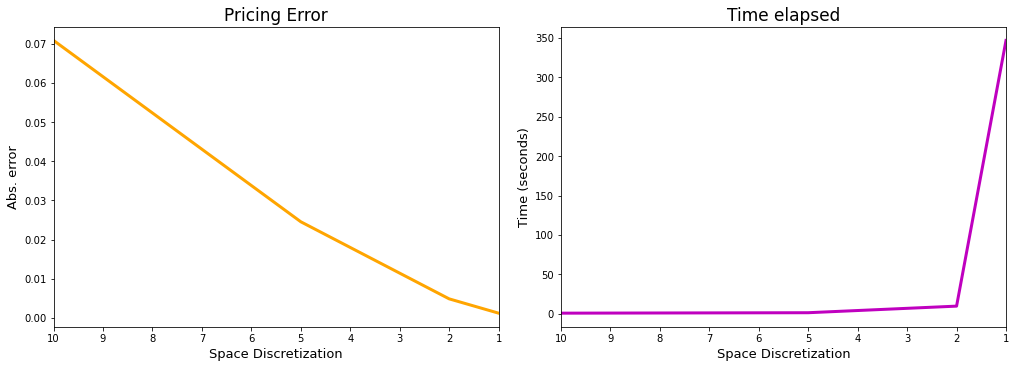

In [20]:
fig,ax=plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
ax[0].set_xlim(10,1)
ax[0].plot(space_discr,FDM_ComptCost['MAE'],'orange',linewidth=3 )
ax[0].set_xlabel('Space Discretization', fontsize=13)
ax[0].set_ylabel('Abs. error',fontsize=13)
ax[0].set_title('Pricing Error', fontsize=17)
ax[1].plot(space_discr,FDM_ComptCost['Time elapsed'],'m',linewidth=3)
ax[1].set_ylabel('Time (seconds)',fontsize=13)
ax[1].set_xlim(10,1)
ax[1].set_xlabel('Space Discretization', fontsize=13)
ax[1].set_title('Time elapsed',fontsize=17)
plt.show()

### Pricing with real stock data 

In [21]:
#AAPL & AMZN stocks
data=yf.download('AAPL AMZN', start='2019-1-1',end='2020-7-23')['Adj Close']
log_returns=np.log(data/data.shift(1))
corr=log_returns.corr().values[0,1]

#Risk free rate
tbill2m=0.0011

#Stock's volatility
sigma_ap=log_returns.std()[0]*np.sqrt(252)
sigma_am=log_returns.std()[1]*np.sqrt(252)

#Prices: accumulated returns (for the stocks to be comparable we divide it price by S0)
prices=data/np.array([data['AAPL'].iloc[0],data['AMZN'].iloc[0]])
Sap=prices['AAPL'].iloc[-1]
Sam=prices['AMZN'].iloc[-1]

#Strike price
K_=1.9

#Temporal discretization, T=3 months
dt_ = 1/252
t_max_ = 2/12

#Spatial discretization
ds = 0.05
Sap_max = 3
Sam_max = 3

#Results table
table=pd.DataFrame(columns=['Price','Time Elapsed','Abs Error'],
                   index=['Exact Solution','Montecarlo','Antithetic Montecarlo','Implicit FDM'])

[*********************100%***********************]  2 of 2 completed


In [22]:
#Exact solution
table['Price'].loc['Exact Solution']=rainbow_MaxCall(Sap,Sam,K_,t_max_,tbill2m,sigma_ap,sigma_am,corr)
table['Time Elapsed'].loc['Exact Solution']=0
table['Abs Error'].loc['Exact Solution']=0

#Montecarlo solution
MC_t0 = time.time()
table['Price'].loc['Montecarlo']=MC_rainbow(t_max_,t_max_,100000,Sap,Sam,K_,tbill2m,sigma_ap,sigma_am,corr)[0]
table['Time Elapsed'].loc['Montecarlo']=time.time()-MC_t0
table['Abs Error'].loc['Montecarlo']=abs(table['Price'].loc['Exact Solution']-table['Price'].loc['Montecarlo'])

#Antithetic Montecarlo solution
AnMC_t0 = time.time()
table['Price'].loc['Antithetic Montecarlo']=AnMC_rainbow(t_max_,t_max_,100000,Sap,Sam,K_,tbill2m,sigma_ap,sigma_am,corr)[0]
table['Time Elapsed'].loc['Antithetic Montecarlo']=time.time()-AnMC_t0
table['Abs Error'].loc['Antithetic Montecarlo']=abs(table['Price'].loc['Exact Solution']-table['Price'].loc['Antithetic Montecarlo'])

#FDM solution
fdm_t0=time.time()
fdm_grid=implicit_FDM(t_max_,dt_,Sap_max,ds,Sam_max,ds,tbill2m,K_,sigma_ap,sigma_am,corr)
table['Price'].loc['Implicit FDM']=fdm_grid[0,50,40]
table['Time Elapsed'].loc['Implicit FDM']=time.time()-fdm_t0
table['Abs Error'].loc['Implicit FDM']=abs(table['Price'].loc['Exact Solution']-table['Price'].loc['Implicit FDM'])

In [23]:
table

,Price,Time Elapsed,Abs Error
Exact Solution,0.620311,0,0
Montecarlo,0.619803,0.010257,0.000508273
Antithetic Montecarlo,0.620175,0.0112491,0.000136203
Implicit FDM,0.606883,15.8391,0.013428
